In [1]:
import acquire
import prepare
import explore
import model
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Project Overview

We will conduct an in depth analysis of Zillow property data from 2017. We will use exploratory analysis techniques to identify the key drivers of the assessed tax value for those properties, then use machine learning algorithms to create a model capable of predicting tax values based on features of the property. 

## Project Description

Property values have skyrocketed over the last two years. With such rapid changes in home values, predicting those values has become even more challenging than before. Since Zillow's estimate of home value is one of the primary drivers of its website traffic, having a reliable estimate is paramount. Any improvement we can make on the previous model will help us out-estimate our competitors and keep us at the top as the most trusted name in real estate technology. 

This project will analyze property attributes in relation to their 2017 assessed tax value, develop a model for predicting that value based on those attributes, and leave with recommendations for how to improve future predictions. 

## Project Goals

By improving upon the previous model, Zillow can enhance it's reputation for reliable property value estimates and better position itself in the real estate technology marketplace. 


# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join together all the relevant data using the following tables:

- properties_2017
- propertylandusetype
- predictions_2017

The data obtained includes all properties in the dataset which had a transaction in 2017.

The `zillow_2017_data` function from the `acquire` module performs this acquisition.

In [2]:
# acquire the data from the Codeup cloud database
df = acquire.zillow_2017_data()

Reading from local CSV...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   fips                          52441 non-null  float64
 6   garagetotalsqft               18015 non-null  float64
 7   poolcnt                       11096 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


# Preparation

In this stage, we clean and prepare the data for further exploration and modeling and encapsulate the relevant code in the prepare modele. 

The `prep_zillow_1` function accomplishes the following:

- replaces null values for garage area and pool count with 0's, since null values likely represent no garage/pool on the property
- checks for null values and removes all rows with null values if the number of null values is less than 5% the number of observations in the dataset. 
    - less than 5% of values is judged to not have a significant effect on a large dataset. Greater than 5% of values might require additional consideration. 
    - in this case we removed about 0.2% of the total observations due to null values
- renames columns for readability
- changes data types where appropriate (such as numerical codes into string values)
- adds a feature 'age', which represents years since the home was constructed

In [4]:
# clean and prep the data using the steps outlined above
df = prepare.prep_zillow_1(df)

The `train_test_validate_split` function **Splits the data** into train, test, and validate samples

In [5]:
# split the data into three samples and print the sample sizes
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 29096
test	 n = 10392
validate n = 12471


**Removing Outliers**

During initial exploration, it was discovered that extreme outliers exist in the categories of tax_value, bedrooms, bathrooms, sqft, and age. 

We judge that out model will generalize more effectively if it is focused on the typical (i.e. median) homes. Further, we expect that markets for luxury and historical homes (likely represented by these outliers) are considerably different than the general home market, and that an altogether separate model would be more useful for predicting the values of such homes. 

We will therefore drop outliers from this dataset. 

The `remove` outliers function calculates a range defining outliers based on the training sample, then removes values outside this range in all samples.

In [6]:
# remove outliers based on a range calculated from the training sample
train, validate, test = prepare.remove_outliers(train, validate, test, 1.5, ['bedrooms', 'bathrooms',
                                                                             'sqft', 'age', 'tax_value',
                                                                             'garage_sqft', 'pools', 'lot_sqft'])

train	 n = 19978
test	 n = 7105
validate n = 8481


# Exploration

### Which features have the highest correlations with tax_value?

The `value_correlations()` function from the `explore` module displays a heatmap of correlations between each feature and our target variable. 

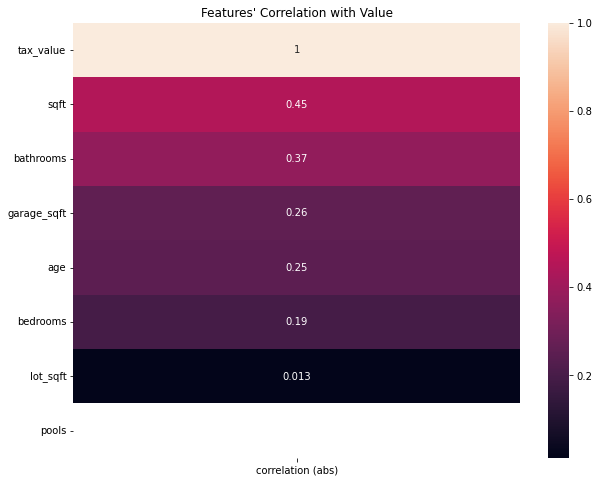

In [7]:
# use seaborn to visualize the correlations with a heatmap
explore.value_correlations(train)

We can see that of our features, sqft and bathrooms have the highest correlation with the tax value of the home. The .48 and .29 r values are considerably higher than the next highest correlation of .23.

Are these correlation values statistically significant?

### Further exploration: Is there a significant correlation between number of bathrooms and value?

The `value_by_bathrooms` function from the `explore` module displays boxplots for each number of bathrooms in our sample. We can see that as the nuber of bathrooms increases, the average value tends to be higher, and the overall distribution of values tends to be higher as well. 

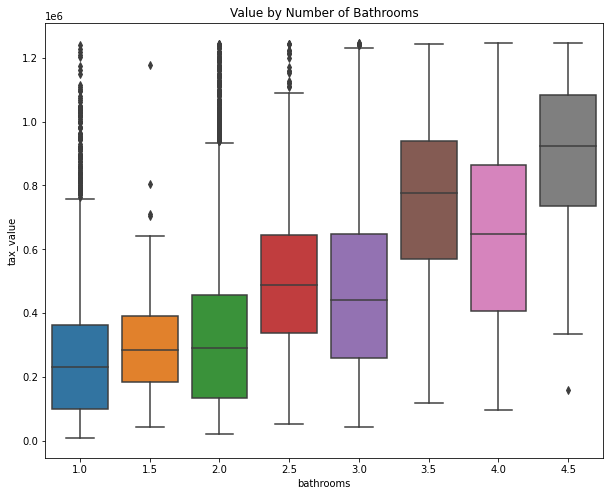

In [8]:
# use seaborn to visualize property value by number of bathrooms with boxplots
explore.value_by_bathrooms(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [9]:
# conduct a statistical test for correlation
explore.correlation_test(train.bathrooms, train.tax_value)

H0: There is no linear correlation between bathrooms and tax_value.
H1: There is a linear correlation between bathrooms and tax_value.

r =  0.37
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between number of bathrooms and tax_value. since this relationship is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between the number of bedrooms in a home and it's value?

The `value_by_bedrooms` function from the `explore` module displays boxplots for each number of bedrooms in our sample. We can see that as the nuber of bedrooms increases, the average value tends to be higher, and the overall distribution of values tends to be higher as well. 

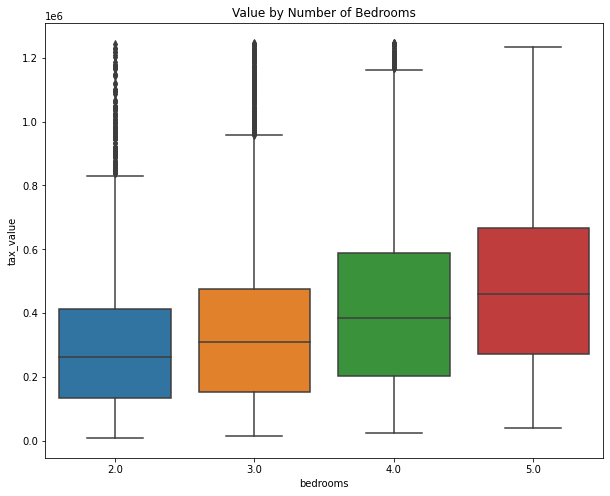

In [10]:
# conduct a statistical test for correlation
explore.value_by_bedrooms(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [11]:
# conduct a statistical test for correlation
explore.correlation_test(train.bedrooms, train.tax_value)

H0: There is no linear correlation between bedrooms and tax_value.
H1: There is a linear correlation between bedrooms and tax_value.

r =  0.19
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the number of bedrooms in a home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between a home's square footage and it's value?

The `sqft_vs_value` function from the `explore` module displays a scatter plot of the relationship between these two variables. 

(a random sample of n=1000 data is used to make the plot less dense))

We can see that, while there does tend to be a wide disbursement of values at all points of the distribution, There is an overall trend of an increase in value as the square footage increases. 

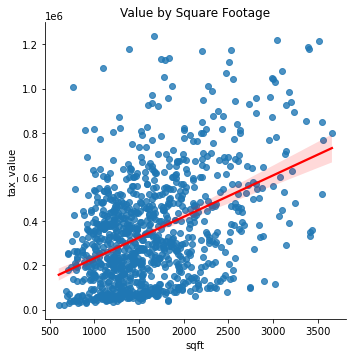

In [12]:
# display a scatter plot with a best-fit line using seaborn
explore.sqft_vs_value(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [13]:
# conduct a statistical test for correlation
explore.correlation_test(train.sqft, train.tax_value)

H0: There is no linear correlation between sqft and tax_value.
H1: There is a linear correlation between sqft and tax_value.

r =  0.45
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the square footage of the home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

## Exploration: Summary

In exploring the relationship between each of the features and our target, we found significant linear correlation between tax value and square footage, bedrooms, and bathrooms. We will use these features in our model moving forward. For simplicity in creating our initial models, we will omit all other variables for the time being. 

Since age of the property also appears to be correlated with value, this is a feature that we may include in subsequent iterations of modeling. 

# Modeling

In [14]:
# identify the name of the target feature
target = 'tax_value'

#### Scaling the data

Next, we will scale the values of each of our quantitative features so that they will be appropriately compared to each other within our models. In this case, we have used a Min-Max scaler, which will convert all values to within a range of 0 to 1. 

The `scale_zillow` function from the `prepare` module performs these scaling actions. 

In [15]:
# scale the data using sklearn MinMaxScaler()
train, validate, test = prepare.scale_zillow(train, validate, test, target)

#### Encoding the data

We will also encode each of our categorical features into a numerical data type that is interpretable by ML algorithms. 

The `encode_zillow` function from the prepare module performs these encoding actions. 

In [16]:
# encode the data using pandas' get_dummies
train, validate, test = prepare.encode_zillow(train, validate, test, target)

#### Establishing Baseline Performance

The code below sets up the necessary infrastructure for storing information about each of our models and their performance

In [17]:
# set the model_number at 0, to be changing with each modeling iteration
model_number = 0 
# create empty dataframes for storing model results and metadata about each model
model_info = pd.DataFrame()
model_results = pd.DataFrame()

Next we will establish our baseline predictions and evaluate their performance. 

To be able to determine whether our model gives useful predictions, we will compare it to a model that uses no features at all, and simply uses the mean value as a prediction for all observations. 

The `run_baseline` function from the `model` stores information about baseline predictions and their performance for later evaluation. 

In [18]:
# create baseline predictions and store information about their performance
model_number, model_info, model_results = model.run_baseline(train, validate, target, model_number, model_info, model_results)

#### Modeling: Ordinary Least Squares (OLS) Regression

The `run_OLS` function from the `model` module creates various OLS Regression models and stores information about their performance for later evaluation, starting with our base set of features (bedrooms, bathrooms, sqft), then iteratively adding features one-by-one. 

In [19]:
# create OLS models and store information about their performance
model_number, model_info, model_results = model.run_OLS(train, validate, target, model_number, model_info, model_results)

#### Modeling: LASSO + LARS

The `run_LassoLars` function from the `model` module runs LASSO + LARS models, again varying the feature sets, and stores information about their performance for later evaluation.


In [20]:
# create LASS+LARS models and store information about their performance
model_number, model_info, model_results = model.run_LassoLars(train, validate, target, model_number, model_info, model_results)

#### Modeling: Polynomial Regression

In [21]:
# create Polynomial Regression models and store information about their performance
model_number, model_info, model_results = model.run_PolyReg(train, validate, target, model_number, model_info, model_results)

## Model Evaluation

**Root Mean Squared Error (RMSE):** This is the metric we will use to evaluate the performance of our models. The RMSE tells us the standard deviation of the difference between our predictions and the actual values and therefore gives us an idea of how spread out the actual data points are around our regression line. Of the possible metrics for evaluating regression models, RMSE is easiest to interpret since it is expressed in units that are equivalent to our target variable (dollars in this case). 

Below, we pull information about the top 3 models and their performance, as well as our baseline performance. 

In [27]:
model.display_model_results(model_results).T

metric_type            RMSE               
sample_type           train       validate
model_number                              
1             220750.487448  221608.074775
2             220749.085790  221633.115176
3             218563.293923  219900.134429
4             218405.106409  219705.875915
5             218405.106409  219705.875915
6             217317.771737  218563.220961
7             220750.750852  221608.736483
8             220749.361549  221631.278825
9             218563.960977  219905.316373
10            218405.835157  219715.899024
11            218405.835157  219715.899024
12            217318.569713  218572.979244
13            220174.486208  221121.315634
14            219964.539454  221083.130992
15            219756.486227  221039.914248
16            219532.331719  221049.146568
17            211678.781796  212476.207406
18            209231.150590  210814.882074
19            207241.487713  211453.168857
20            204154.037701  230688.502286
baseline      248815.692506  249077.903815

In [23]:
model.display_model_results(model_results[model_results.model_number == 'baseline'])

model_number                  baseline
metric_type sample_type               
RMSE        train        248815.692506
            validate     249077.903815

In [24]:
# get and display performance metrics for the top 3 models
best_model_results = model.get_best_model_results(model_results)
model.display_model_results(best_model_results)

model_number                        17             18             19
metric_type sample_type                                             
RMSE        train        211678.781796  209231.150590  207241.487713
            validate     212476.207406  210814.882074  211453.168857

In [25]:
# display information about the top 3 models
model_info[(model_info.model_number == 17)|(model_info.model_number == 18)|(model_info.model_number == 19)]

,model_number,model_type,features,alpha,degree
17,17,Polynomial Regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf...",NaN,2.0
18,18,Polynomial Regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf...",NaN,3.0
19,19,Polynomial Regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf...",NaN,4.0


#### Modeling - Final Test

Now we will take the best model and evaluate its performance on our test sample. This will approximate the expected performance of this model for predicting prices of additional properties in real-time.

**Model 18**, a Polynomial Regression to the 4th degree, is our highest performing model. 

It has an RMSE of 209,231 on the train sample and **210,815** on the validate sample. 

It uses the following features:

- bedrooms
- bathrooms
- square feet
- age, 
- garage area
- lot size
- number of pools
- location by FIPS code

The `final_test_model18` function recreates the model and tests it's results.

In [26]:
# calculate the RMSE for model 18
model.final_test_model18(train, test, target)

Model 3 RMSE:  $217,714.27


# How did we do?

We expect that our model will typically predict a value that is within approximately \$218,000 of the actual value of the property. This large of an error makes this not an exceptionally useful model in many cases. However, this is 31,000 better than our baseline error of approximately 249,000. This indicates that we have successfully identified drivers of home value, and gives us a jumping off point for further analysis and modeling. 

### Key Findings:

We determined that the following factors are the some of the most significant drivers of home value:
- number of bathrooms
- square footage (of principal residence)

### Recommendations:

Zillow should continue to collect data regarding the number of bedrooms and bathrooms in a home, as well as the home's area in square feet. This data has been conclusively shown to assist in predicting home values. If using this analysis to decide which homes are worth investing in, an investor should lean towards homes with higher values in these categories, all other considerations being equal. 

### Next Steps: 

**Deeper Analysis**: Given more time, I would do a deeper exploration of the other features included in our best performing models, including additional visualizations and statistical testing.

**Feature Selection and Engineering**: Additionally, I would explore the other features available in the dataset, which could be done directly through visualization and statistical testing, or they could be identified through automated features selection techniques such as Recursive Feature Elimination. 

**Narrow the Focus**: Further, since real estate markets are based heavily on location, we should expect models to perform better which individually focus on a distinct geographic area. 

**Additional Data**: In addition to narrowing by geography, perhaps the most effective way to improve this model would be to gather additional information about the surrounding geography of each property, such as school quality, crime rates, etc.

The goal would be to produce a model that has an error small enough to be useful to someone intending to sell or purchase a single family home. 